In [1]:
from load import *
from torch import Tensor, nn
import torch
from model_base import *
from modules import *
from anim import *
import util
import matplotlib.pyplot as plt
from tqdm import trange
from derivative import NormalizedPoissonRMSE

ROOT = "./Datas/Week 8"

Q = 1.60217663e-19

In [2]:
sc = load_space_charge() * -Q
ep = load_elec_potential()
vg = load_vgs()
poi = NormalizedPoissonRMSE('cpu')
poi(ep, sc)

tensor(5.3032e-10, dtype=torch.float64)

In [3]:
def extract(ep, sc):
    xep = ep.reshape(-1, 129, 17)
    xsc = sc.reshape(-1, 129, 17)
            
    ep_region_2 = xep[:, 45:84,:11].reshape(-1, 429)
    ep_region_5 = xep[:, 45:84,11:].reshape(-1, 234)
    sc_region_2 = xsc[:, 45:84,:11].reshape(-1, 429)

    joined = torch.cat([ep_region_2, ep_region_5, sc_region_2], dim = 1)

    return joined

def reconstruct(x, xep, xsc):
    ep_region_2 = x[:, :429].reshape(-1, 39, 11)
    ep_region_5 = x[:, 429:663].reshape(-1, 39, 6)
    sc_region_2 = x[:, 663:].reshape(-1, 39, 11)

    xep = xep.clone()
    xep[:, 45:84,:11] = ep_region_2
    xep[:, 45:84,11:] = ep_region_5
    xep = xep.reshape(-1, 129, 17)

    xsc = xsc.clone()
    xsc[:, 45:84,:11] = sc_region_2
    xsc = xsc.reshape(-1, 129, 17)

    return xep, xsc

In [4]:
class PrincipalComponentExtractor(Model):
    """Takes the tensor x, and returns the principal d dimensions by calculating its covariance matrix. d indicates the number of principal components to extract"""
    def __init__(self, d: int, /, device = None):
        self.d = d
        self.eigenvectors = None

        if device is None:
            self._device = get_device()
        else:
            self._device = device

    def fit(self, X: Tensor):
        """X is a (n_data, n_features). This computes the projection data for PCA. Returns None. If you really need to access the projection data, it is at `model.pdata` and it should be a tensor with shape (N, n_features). The sorted eigenvalues is at `model.eigenvalues` and the sorted eigenvectors are at `model.eigenvectors`"""
        cov = torch.cov(X.T.float())
        l, v = torch.linalg.eigh(cov)

        self.eigenvalues, sorted_eigenidx = torch.abs(l.double()).sort(descending=True)
        self.eigenvectors = v[:, sorted_eigenidx].double()

    def project(self, X: Tensor) -> Tensor:
        """X is a (n_data, n_features) tensor. This performs the projection for you and returns an (n_data, d) tensor. Raises a runtime error if n_features does not match that in training"""
        if self.eigenvectors is None:
            raise RuntimeError("Projection data has not been calculated yet. Please first call model.fit()")
        
        if X.shape[1] != self.eigenvectors.shape[0]:
            raise RuntimeError(f"Expects {self.eigenvectors.shape[0]}-dimensional data due to training. Got {X.shape[1]}-d data instead.")
        
        components = X.double() @ self.eigenvectors[:, :self.d]
        return components
    
    def unproject(self, X: Tensor):
        """Try to compute the inverse of model.project(X). The input is a tensor of shape (n_data, d) and returns a tensor of (n_data, n_features)"""
        # XP = X* so given X* we have X = X*P⁻¹
        # Problem is P is a matrix of shape (n_features, d), so we need to make it square first to take inverse.
        # However, P is originally (n_features, n_features) big which we can take inverses, the reason
        # P has the shape (n, d) is because it is actually the combination of the real P matrix followed by extracting first N columns
        # We use a workaround: append zeros on X until it has enough features, then use the full P inverse
        if self.eigenvectors is None:
            raise RuntimeError("Projection data has not been calculated yet. Please first call model.fit()")

        X_ = torch.zeros(X.shape[0], self.eigenvalues.shape[0]).double()
        X_[:, :X.shape[1]] = X
        result = X_ @ torch.linalg.pinv(self.eigenvectors)
        return result
        
    
    def forward(self, X: Tensor) -> Tensor:
        """fit followed by project."""
        self.fit(X)
        return self.project(X)

In [5]:
index = util.TRAINING_IDXS[f"First 30"]

x = vg[index]
epy = ep[index]
scy = sc[index]

# ep_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, epy.reshape(-1, 2193))
# sc_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, scy.reshape(-1, 2193))

pca = PrincipalComponentExtractor(1092, device = 'cpu')
extracted = extract(epy, scy)
pca.fit(extracted)

100%|██████████| 1092/1092 [09:52<00:00,  1.84it/s]


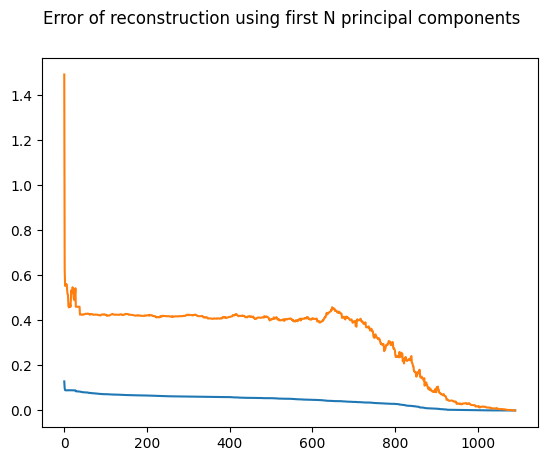

In [6]:
def f(a):
    X = torch.tensor([a])
    X = pca.unproject(X)
    rep, rsc = reconstruct(X, epy[-1:], scy[-1:])
    rpl = NormalizedPoissonRMSE('cpu')
    mse = rpl(rep, rsc)
    return mse.item()

def g(i):
    pca = PrincipalComponentExtractor(i + 1, device = 'cpu')
    pca.fit(extracted)
    a = extracted - pca.unproject(pca.project(extracted))
    return i, torch.mean(torch.abs(a)).item(), torch.max(torch.abs(a)).item()

r = []
for i in trange(1092):
    r.append(g(i))
# r = map(g, trange(1092))
results = [a[1:] for a in sorted(r, key=lambda x: x[0])]

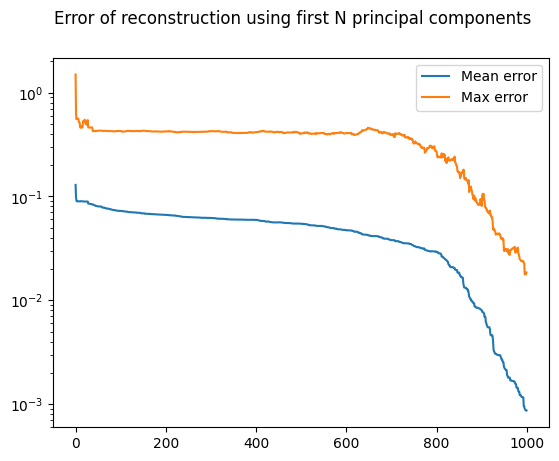

In [8]:
fig, ax = plt.subplots()
ax.plot(results[:1000], label=["Mean error", "Max error"])
fig.suptitle("Error of reconstruction using first N principal components")
ax.legend()
ax.set_yscale('log')
pass